# Lab 3

### Team Members:
 - Alex Lopez
 - Chris Haub
 - Erin McClure-Price
 - Chad Kwong

#### Library Imports

In [54]:
#Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Import Scaling Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import plotly.express as px #EMP used for some outlier stuff
from scipy import stats #EMP used for some outlier stuff

#KMeans and silhouette score
from sklearn.metrics import silhouette_score
from sklearn.cluster import k_means
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#Importing random library for different options of setting seeds
import random

#Grid Search library
from sklearn.model_selection import GridSearchCV
from sklearn import metrics as mt

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Setting Random State for replicability
randomState = 777
random.seed(2000)

#### Data Import

In [2]:
%%time

#Loading all data file separately 
vle = pd.read_csv('./anonymiseddata/vle.csv')
assessments = pd.read_csv('./anonymiseddata/assessments.csv')
courses = pd.read_csv('./anonymiseddata/courses.csv')
studentAssessments = pd.read_csv('./anonymiseddata/studentAssessment.csv')
studentInfo = pd.read_csv('./anonymiseddata/studentInfo.csv')
studentRegistration = pd.read_csv('./anonymiseddata/studentRegistration.csv')
studentVle = pd.read_csv('./anonymiseddata/studentVle.csv')

CPU times: user 3.6 s, sys: 703 ms, total: 4.3 s
Wall time: 4.39 s


# Business Understanding 1 #
*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

For Lab 3 we chose to use the "Open University Learning Analytics Dataset" (OULAD) which is an anonymized collection of information acquired from online students who were enrolled in the Open University (Milton Keynes, England) in 2013-2014. The OULAD was originally collected to better understand how students perform in an online-only environment by gathering information about their assessment (grade) results in addition to the frequency of usage with the online platforms. The data includes student demographic and registration information, as well as assessment results and interactions with the Virtual Learning Environment (VLE). There are multiple ways that the OULAD can be utilized, including prediction of grade results, better understanding of the factors that influence online student outcomes, or to compare online student results to in-person student results. The reason why this dataset is important is because it can be used by educators and universities to increase student success within an online learning environment. 

Our goal for Lab 3 was to explore the OULAD using K-Means clustering in order to find trends and insight into student learning styles. We chose K-Means clustering because it is an unsupervised algorithm that is straightforward to carry out, scalable, and can be used for large datasets. Our goal was to identify which features were associated with higher performance in terms of academic performance.

We chose to evaluate the clustering model using the Silhouette Score, which calculates the distance between a data point and its assigned cluster. The Silhouette Score ranges from -1 to +1, and the closer the value is to +1 indicates that the means of the clusters are well-separated while a value closer to -1 indicates that the clusters are not distinct. We felt that the Silhouette Score was ideal because it provides a numeric value to the fitness of a cluster in addition to finding the optimal number of clusters for a given dataset.

An additional tool we chose to use was Robust Scaler, an algorithm that scales the data to its interquartile range. Using the Robust Scaler was a way to standardize our data and remove any issues arising from outliers that could bias the outcome of the analysis.

##### References
[Kaggle: OULAD](https://www.kaggle.com/datasets/rocki37/open-university-learning-analytics-dataset)

[sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

[Silhouette Coefficient](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

[A Simple Explanation of K-Means Clustering](https://www.analyticsvidhya.com/blog/2020/10/a-simple-explanation-of-k-means-clustering/)

# Data Understanding 1 #
*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

### Data Description

The OULAD dataset is derived from a relational database schema, and contains seven CSV files that encompasses data collected from 32,593 students that were enrolled in 22 courses. There are a total of 43 variables and over 10 million instances. The CSV files and their contents are described below, information regarding each variable was taken from [HERE](https://analyse.kmi.open.ac.uk/open_dataset). It should be noted that "modules" refer to university courses and VLE refers to "virtual learning environment". Due to the nature of the data, there are duplicate entries as all 32,593 students took multiple courses

#### Courses:
* code_module **(categorical)** - code for the module, which serves as the identifier
* code_presentation  **(categorical)**– code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
* length **(numeric)** - length of the module-presentation in days.

#### Assessments
* code_module **(categorical)** – identification code of the module, to which the assessment belongs.
* code_presentation **(categorical)** - identification code of the presentation, to which the assessment belongs.
* id_assessment **(numeric)** – identification number of the assessment.
* assessment_type **(categorical)** – type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
* date **(numeric)** – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
* weight **(numeric)** - weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.

#### VLE
* id_site **(numeric)** – an identification number of the material.
* code_module **(categorical)** – an identification code for module.
* code_presentation **(categorical)** - the identification code of presentation.
* activity_type **(categorical)** – the role associated with the module material.
* week_from **(numeric)** – the week from which the material is planned to be used.
* week_to **(numeric)** – week until which the material is planned to be used.;

#### StudentInfo
* code_module **(categorical)** – an identification code for a module on which the student is registered.
* code_presentation **(categorical)** - the identification code of the presentation during which the student is registered on the module.
* id_student **(numeric)** – a unique identification number for the student.
* gender **(categorical)** – the student’s gender.
* region **(categorical)** – identifies the geographic region, where the student lived while taking the module-presentation.
* highest_education **(categorical)** – highest student education level on entry to the module presentation.
* imd_band **(categorical)** – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.
* age_band **(numeric)** – band of the student’s age.
* num_of_prev_attempts **(numeric)** – the number times the student has attempted this module.
* studied_credits **(numeric)** – the total number of credits for the modules the student is currently studying.
* disability **(categorical)**  – indicates whether the student has declared a disability.
* final_result **(categorical)** – student’s final result in the module-presentation.

#### StudentRegistragion
* code_module **(categorical)** – an identification code for a module.
* code_presentation **(categorical)** - the identification code of the presentation.
* id_student **(numeric)** – a unique identification number for the student.
* date_registration **(numeric)** – the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).
* date_unregistration **(numeric)** – date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

#### StudentAssessment
* id_assessment **(numeric)** – the identification number of the assessment.
* id_student **(numeric)** – a unique identification number for the student.
* date_submitted **(numeric)** – the date of student submission, measured as the number of days since the start of the module presentation.
* is_banked **(numeric)** – a status flag indicating that the assessment result has been transferred from a previous presentation.
* score **(numeric)** – the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

#### StudentVLE
* code_module **(categorical)** – an identification code for a module.
* code_presentation **(categorical)** - the identification code of the module presentation.
* id_student **(numeric)** – a unique identification number for the student.
* id_site **(numeric)** - an identification number for the VLE material.
* date **(numeric)** – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.
* sum_click **(numeric)** – the number of times a student interacts with the material in that day.



The OULAD was originally used in a relational database schema with separated tables, hence the seven CSV files. In order to create a clustering model, we needed to merge these tables together into a singular dataframe. We found that using data from all of the 32,000 students was too intensive, and even sampling as few as 35 students resulted in 88,676 instances that took our machines hours to to calculate. Eventually, we settled on taking a random sample of 30 students for a total of 53,957 instances which more than covered the minimal number of transactions required for the project.  

In [3]:
%%time
# Randomly sampling 40 students to generate dataset
studentSample = studentInfo.sample(n=30, random_state = randomState)
print(studentSample.shape)

# vle
# assessments X
# courses X
# studentAssessments X
# studentInfo X
# studentRegistration X
# studentVleSample X

# compiling dataframe from data files
df = pd.merge(studentSample, studentVle, on=['code_module', 'code_presentation', 'id_student'])
df2 = pd.merge(studentAssessments, assessments, on='id_assessment')
df = pd.merge(df, df2, on=['code_module', 'code_presentation', 'id_student'], how='left')
df = pd.merge(df, courses, on= ['code_module', 'code_presentation'], how='left')
df = pd.merge(df, studentRegistration, on=['code_module', 'code_presentation', 'id_student'], how='left')
df = pd.merge(df, vle, on=['id_site', 'code_module', 'code_presentation'], how='left')

print(df.shape)
df.head()

(30, 12)
(53957, 28)
CPU times: user 1.49 s, sys: 395 ms, total: 1.88 s
Wall time: 1.92 s


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,score,assessment_type,date_y,weight,module_presentation_length,date_registration,date_unregistration,activity_type,week_from,week_to
0,CCC,2014J,134190,F,Scotland,A Level or Equivalent,30-40%,0-35,0,120,...,78.0,CMA,18.0,2.0,269,-70.0,32.0,homepage,NaN,NaN
1,CCC,2014J,134190,F,Scotland,A Level or Equivalent,30-40%,0-35,0,120,...,78.0,CMA,18.0,2.0,269,-70.0,32.0,resource,NaN,NaN
2,CCC,2014J,134190,F,Scotland,A Level or Equivalent,30-40%,0-35,0,120,...,78.0,CMA,18.0,2.0,269,-70.0,32.0,forumng,NaN,NaN
3,CCC,2014J,134190,F,Scotland,A Level or Equivalent,30-40%,0-35,0,120,...,78.0,CMA,18.0,2.0,269,-70.0,32.0,forumng,NaN,NaN
4,CCC,2014J,134190,F,Scotland,A Level or Equivalent,30-40%,0-35,0,120,...,78.0,CMA,18.0,2.0,269,-70.0,32.0,homepage,NaN,NaN


### Duplicates

We checked the dataset for duplicate entries and found that there were 4,593 duplicates. We chose to remove these duplicate entries before moving on to check missing values.

In [4]:
df.duplicated().sum()

4593

In [5]:
df.drop_duplicates(keep = 'first', inplace = True)
df.duplicated().sum()

0

### Missing Values

From the cell below, we saw that date_unregistration had null entries in over 96% of the data, and both week_from and week_to had null entries for over 86% of the data. Since these columns seemed to be unnecessary, we chose to drop all three as they consisted mostly of missing values. 

Running the same code on the dataset after dropping the three columns showed that the percentages of missing values in the remaining columns were zero except for "date_y" which had less than 3% missing values.

In [6]:
print('Missing values: \n', df.isnull().sum() * 100 / len(df),'\n\n')
missingValues = df[df.isnull()]
try:
    df = df.drop(columns = ['week_from', 'week_to', 'date_unregistration'])
except:
    print('These columns have already been dropped\n\n')
print('Missing values after dopping columns: \n', df.isnull().sum() * 100 / len(df))

Missing values: 
 code_module                    0.000000
code_presentation              0.000000
id_student                     0.000000
gender                         0.000000
region                         0.000000
highest_education              0.000000
imd_band                       0.000000
age_band                       0.000000
num_of_prev_attempts           0.000000
studied_credits                0.000000
disability                     0.000000
final_result                   0.000000
id_site                        0.000000
date_x                         0.000000
sum_click                      0.000000
id_assessment                  0.000000
date_submitted                 0.000000
is_banked                      0.000000
score                          0.000000
assessment_type                0.000000
date_y                         2.937363
weight                         0.000000
module_presentation_length     0.000000
date_registration              0.000000
date_unregistration   

In [7]:
df.dropna(inplace=True)
try:
    df.drop(columns=['id_student','id_assessment','id_site','code_module','code_presentation'],inplace=True)
except:
    print("These columns have already been dropped")
    
#converting variables to their correct type
df.date_registration = df['date_registration'].astype(int)
df.date_y = df['date_y'].astype(int)
df.score = df['score'].astype(int)
df.num_of_prev_attempts = df['num_of_prev_attempts'].astype(object)
df.studied_credits = df['studied_credits'].astype(object)
df.is_banked = df['is_banked'].astype(object)
df.module_presentation_length = df['module_presentation_length'].astype(object)

df.shape

(47914, 20)

We converted Date_registration, date_y, and score to integer values since there were no counts of values with decimals. We also converted num_of_prev_attempts, studied_credits, is_banked, and module_presentation_length to objects.

### One Hot Encoding

As shown in the code output below, many of the variables in the OULAD were categorical making it necessary to One Hot Encode the data in order to analyze it.

In [8]:
df.dtypes

gender                         object
region                         object
highest_education              object
imd_band                       object
age_band                       object
num_of_prev_attempts           object
studied_credits                object
disability                     object
final_result                   object
date_x                          int64
sum_click                       int64
date_submitted                  int64
is_banked                      object
score                           int64
assessment_type                object
date_y                          int64
weight                        float64
module_presentation_length     object
date_registration               int64
activity_type                  object
dtype: object

In [9]:
# View unique values in each column
# for col in df:
#   print(df[col].unique())

In [10]:
#Creating variables for indexing continuous and categorical variables
conCol = ['date_x', 'sum_click', 'date_submitted', 'score', 'date_y', 'weight', 'date_registration']

catCol = ['gender', 'region', 'highest_education', 'is_banked',  'num_of_prev_attempts', 'studied_credits',
          'imd_band', 'age_band', 'disability', 'final_result', 'assessment_type', 'module_presentation_length', 'activity_type']

The following cell scales the data using a standard scaling technique and one hot encodes the dataset including outliers.

In [11]:
%%time
#Declaring Scalar object
scl_obj = StandardScaler()
#scl_obj = RobustScaler()

#One hot encoding of ALL categorical variables
OneHotDF = pd.get_dummies(df[catCol],drop_first=False)

#Scaling non-encoded data
conVar = df.select_dtypes(exclude='object')
colnames = pd.Series(conVar.columns)
conVarScaled = scl_obj.fit_transform(conVar)
conVarScaled = pd.DataFrame(data = conVarScaled, columns= colnames)

#Combining with continuous variables from cleaned dataset
OneHotDF = OneHotDF.reset_index()
OneHotDF.pop('index')
OneHotDF = pd.concat([conVarScaled,OneHotDF], axis = 1)
OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb


CPU times: user 85.5 ms, sys: 12.4 ms, total: 97.9 ms
Wall time: 102 ms


,date_x,sum_click,date_submitted,score,date_y,weight,date_registration,gender_F,gender_M,region_East Anglian Region,...,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
0,-1.597173,-0.417423,-1.41937,-0.042726,-1.451877,-0.745647,-0.569523,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.597173,-0.417423,-1.41937,-0.042726,-1.451877,-0.745647,-0.569523,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.359935,-0.417423,-1.41937,-0.042726,-1.451877,-0.745647,-0.569523,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.359935,-0.243497,-1.41937,-0.042726,-1.451877,-0.745647,-0.569523,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.359935,0.452205,-1.41937,-0.042726,-1.451877,-0.745647,-0.569523,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Outliers

Even though we planned to use the Robust Scaler, since the OULAD was entirely numeric we could look through the data for outliers. The code below was used to calculate the 25th and 75th quantiles from the data and then report the columns that had values outside of the interquantile range (IQR). 

In [12]:
Q1 = OneHotDF[conCol].quantile(0.25)
Q3 = OneHotDF[conCol].quantile(0.75)
IQR = Q3 - Q1
# print(IQR)

IQRDF = pd.DataFrame(data = {'Q1':Q1, 'Q3':Q3, 'IQR':IQR})
IQRDF.index.name = 'Variable Name'
IQRDF['lowerGate'] = Q1-1.5*IQR
IQRDF['upperGate'] = Q3+1.5*IQR
IQRDF.sort_values(by='IQR', ascending=False)

,Q1,Q3,IQR,lowerGate,upperGate
Variable Name,,,,,
date_y,-0.884680,1.041152,1.925832,-3.773428,3.929900
date_submitted,-0.992433,0.791555,1.783988,-3.668415,3.467537
date_x,-0.924998,0.788389,1.713387,-3.495078,3.358469
date_registration,-0.777378,0.781530,1.558908,-3.115740,3.119892
weight,-0.809064,0.522701,1.331766,-2.806713,2.520350
score,-0.472970,0.817762,1.290732,-2.409067,2.753860
sum_click,-0.417423,-0.069572,0.347851,-0.939200,0.452205


The code below was used to check for rows that were outside the range of the lower and upper bounds. 

In [13]:
print(df[conCol].describe())

for i in range(0,len(IQRDF.index)):
    lowerCount = len((OneHotDF[OneHotDF[IQRDF.index[i]] < IQRDF.lowerGate[i]]))
    upperCount = len((OneHotDF[OneHotDF[IQRDF.index[i]] > IQRDF.upperGate[i]]))

    if ((lowerCount !=0) & (upperCount !=0)):
        print('The number of outliers outside the lower and upper gates for the '+ 
              IQRDF.index[i] + ' variable is', lowerCount + upperCount)
    else:
        print('There are outliers for the ' + IQRDF.index[i] + ' variable.')

             date_x     sum_click  date_submitted         score        date_y  \
count  47914.000000  47914.000000    47914.000000  47914.000000  47914.000000   
mean     105.182473      3.400008      114.087114     78.794444    128.068832   
std       75.873907      5.749644       65.584087     18.594296     75.812181   
min      -25.000000      1.000000       10.000000     10.000000     12.000000   
25%       35.000000      1.000000       49.000000     70.000000     61.000000   
50%      107.000000      2.000000      119.000000     80.000000    124.000000   
75%      165.000000      3.000000      166.000000     94.000000    207.000000   
max      268.000000     98.000000      241.000000    100.000000    261.000000   

             weight  date_registration  
count  47914.000000       47914.000000  
mean      13.757764         -48.079914  
std       15.768704          38.488883  
min        0.000000        -165.000000  
25%        1.000000         -78.000000  
50%       10.000000     

According to the results printed above, there were outliers within the dataset. In the code below, we created a new dataset with the outliers removed so that we could compare results from a dataset with outliers removed to results from a dataset with outliers.

In [14]:
ohdf = OneHotDF
print('shape before removing outliers:',ohdf.shape)
ohdf = ohdf[~((ohdf < (Q1 - 1.5 * IQR)) |(ohdf > (Q3 + 1.5 * IQR))).any(axis=1)]
print('shape after removing outliers:',ohdf.shape)
ohdf.info()

shape before removing outliers: (47914, 76)
shape after removing outliers: (39778, 76)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39778 entries, 0 to 47913
Data columns (total 76 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   date_x                                   39778 non-null  float64
 1   sum_click                                39778 non-null  float64
 2   date_submitted                           39778 non-null  float64
 3   score                                    39778 non-null  float64
 4   date_y                                   39778 non-null  float64
 5   weight                                   39778 non-null  float64
 6   date_registration                        39778 non-null  float64
 7   gender_F                                 39778 non-null  uint8  
 8   gender_M                                 39778 non-null  uint8  
 9   region_East Anglian Region   

In [34]:
sc = RobustScaler()
data_clust = sc.fit_transform(ohdf)
data_clust.shape

(39778, 76)

The following cell creates a one hot encoded dataframe that includes outliers but uses robust scaling to approach the outliers to avoid dropping data

In [ ]:
#Declaring Scalar object using Robust Scaling
scl_obj = RobustScaler()

#One hot encoding of ALL categorical variables
OneHotDF2 = pd.get_dummies(df[catCol],drop_first=False)

#Scaling non-encoded data
conVar = df.select_dtypes(exclude='object')
colnames = pd.Series(conVar.columns)
conVarScaled = scl_obj.fit_transform(conVar)
conVarScaled = pd.DataFrame(data = conVarScaled, columns= colnames)

#Combining with continuous variables from cleaned dataset
OneHotDF2 = OneHotDF2.reset_index()
OneHotDF2.pop('index')
OneHotDF2 = pd.concat([conVarScaled,OneHotDF2], axis = 1)

# Data Understanding 2 #
*Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

We wanted to check the relationships of some of the variables, so we created two functions in the cell below to analyze the data. We used the dataset with no outlier treatment. It should be continously noted that the sample used for the following figures was severely reduced and it is  unlikely that our sample is sufficient to reflect the actual distributions of the original dataset.

The first function creates a stacked boxplot of a categorical variable compared to "Final_Result" (AKA: final grade at the end of the course) as well as outputs the counts of each categorical level per final_result level.

The second function was used to create a series of box plots and histograms for the continuous variables, this was done so that we could check for outliers and distributions. A triangle symbol in the box plots indicates the mean value.

In [15]:
def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,df['final_result'],margins=True)
    print(tab1)
    print('-'*100)
    tab = pd.crosstab(x,df['final_result'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(15,5))
    #plt.legend(loc='lower left', frameon=False)
    #plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1))
    plt.show()
    
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, color="orange"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2, color="tab:cyan"
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

The first variable we looked at was "gender", we found that the distribution of between males and females for each level of final_result varied, with no "Distinction" results occurring in the Female level and significantly more "Fail" results when compared to the Male level. However, it should be noted that the random sample taken from the complete dataset appeared to be skewed towards male students with a total of 38,595 vs 13,780 for female students. It is possible that increasing the size of the random sample of students would result in a more equal distribution of grade results and gender. 

final_result  Distinction  Fail   Pass  Withdrawn    All
gender                                                  
F                       0  3327   7661       1351  12339
M                    8592  1428  20630       4925  35575
All                  8592  4755  28291       6276  47914
----------------------------------------------------------------------------------------------------


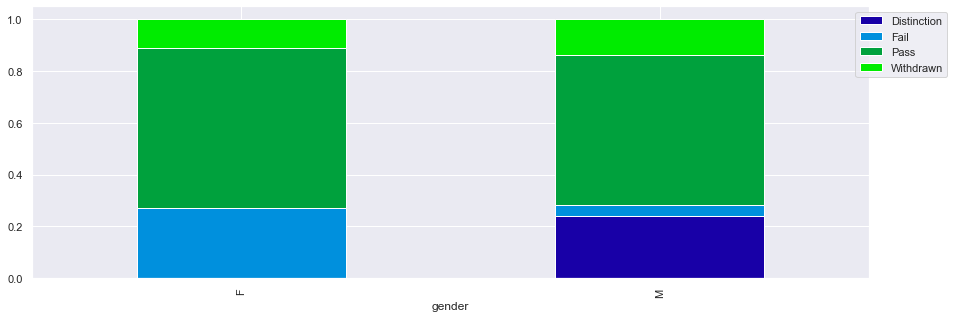

In [16]:
stacked_plot(df["gender"])

The next categorical variable we examined was "Region". It was notable that all grade results for the London Region were "Fail" and the South West Region consisted entirely of "Withdrawn" results. The East Anglian and Yorkshire region showed results only for "Fail" and "Pass", with "Fail" taking the majority in both regions. The North Western and South East regions had the only students to receive "Distinction" grades while all students in the South West region had "Withdrawn" results.

final_result          Distinction  Fail   Pass  Withdrawn    All
region                                                          
East Anglian Region             0  2036   1107          0   3143
London Region                   0  1290      0          0   1290
North Western Region         1592     0      0       5960   7552
Scotland                        0     0   1160        243   1403
South East Region            7000     0  16211         48  23259
South Region                    0    22   7849          0   7871
South West Region               0     0      0         25     25
West Midlands Region            0   138    812          0    950
Yorkshire Region                0  1269   1152          0   2421
All                          8592  4755  28291       6276  47914
----------------------------------------------------------------------------------------------------


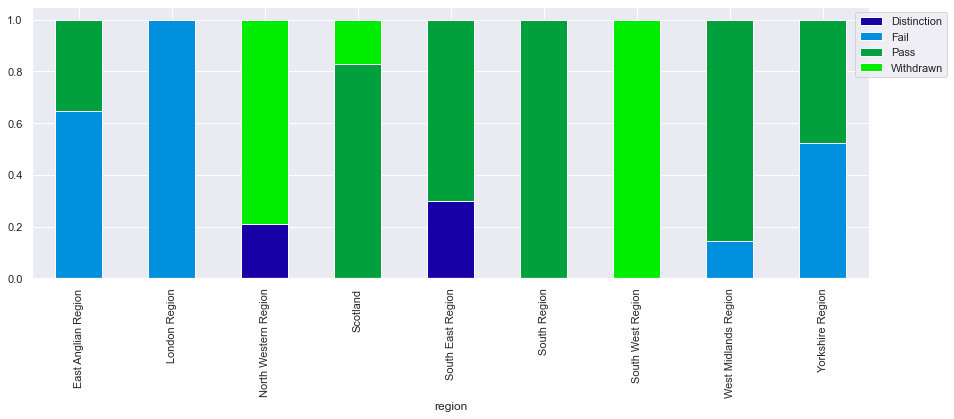

In [17]:
stacked_plot(df["region"])

The results for "imd_band" (Indices of Multiple Deprivation - a measure of poverty where lower percentages indicate increased poverty) indicated that all students in the 0-10% and 90-100% bands passed their courses. The 10-20% band was almost equally distributed between "Fail" and "Withdrawn" results, and the 50-60% band consisted entirely of "Fail" results. The 70-80% IMD band had the most believable distribution, with results representing all four levels of the variable.

final_result  Distinction  Fail   Pass  Withdrawn    All
imd_band                                                
0-10%                   0     0    812          0    812
10-20                   0  1269      0       1250   2519
30-40%                  0     0      0        243    243
40-50%                  0     0   5630         73   5703
50-60%                  0  1290      0          0   1290
60-70%                  0    22  15873          0  15895
70-80%               1592  2040   1664       4710  10006
80-90%               7000   134   3205          0  10339
90-100%                 0     0   1107          0   1107
All                  8592  4755  28291       6276  47914
----------------------------------------------------------------------------------------------------


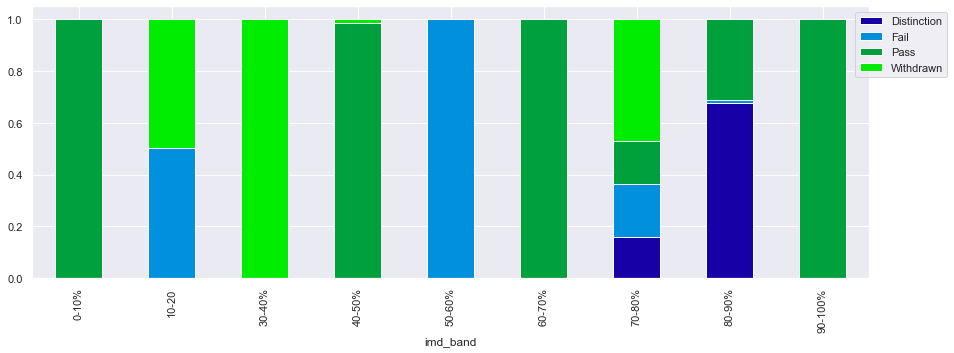

In [18]:
stacked_plot(df["imd_band"])

For the "activity_type" variable, we noted that those students who only referenced the "shared sub page" had entirely withdrawn results while those students "dataplus", "folder", "glossary", and "questionairre" pages had entirely "pass" results. One other notable variable was the "ouelluminate" column, which showed entirely "fail" results.

final_result   Distinction  Fail   Pass  Withdrawn    All
activity_type                                            
dataplus                 0     0     12          0     12
dualpane                 8     0     48          0     56
externalquiz             0    18    115         18    151
folder                   0     0     24          0     24
forumng               1100   504   6105       2524  10233
glossary                 0     0     27          0     27
homepage              1640  1091   5988       1236   9955
oucollaborate           12    50    295        110    467
oucontent             2608   505   5321        222   8656
ouelluminate             0     2      0          0      2
ouwiki                  84     2    806          0    892
page                     8     2    116          0    126
questionnaire            0     0    120          0    120
quiz                   308   521   1964        154   2947
resource              1628   737   1954        903   5222
sharedsubpage 

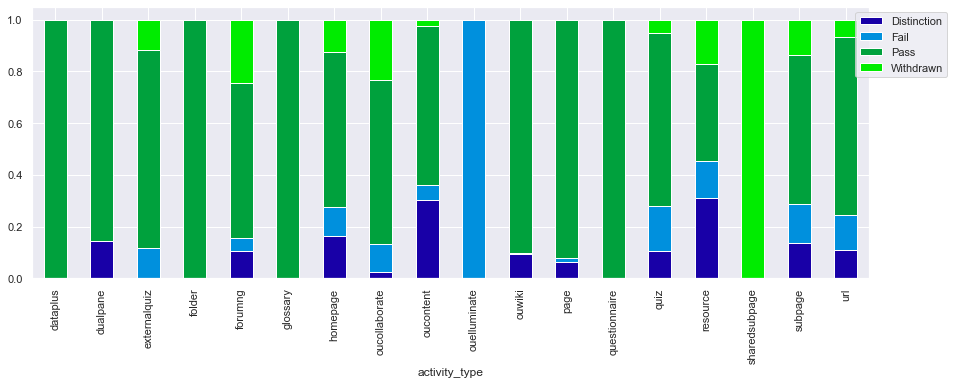

In [19]:
stacked_plot(df["activity_type"])

When comparing ages of students vs final_result, we found that there were no "Distinction" results in the 35-55 age band. There were significantly more "Fail" and "Withdrawn" results for the 35-55 age band (3,402 and 5,426) vs the 0-35 age band (1,791 and 1,554).

These results are logical in the sense that the age band at 0-35 would include younger students who are starting a career by pursuing a degree, while students from 35-55 could possibly just be taking furthering education courses or, in the case of already being in a career, limited in the amount of time they can devote to a course.

final_result  Distinction  Fail   Pass  Withdrawn    All
age_band                                                
0-35                 8592  1563  16896       1424  28475
35-55                   0  3192  11395       4852  19439
All                  8592  4755  28291       6276  47914
----------------------------------------------------------------------------------------------------


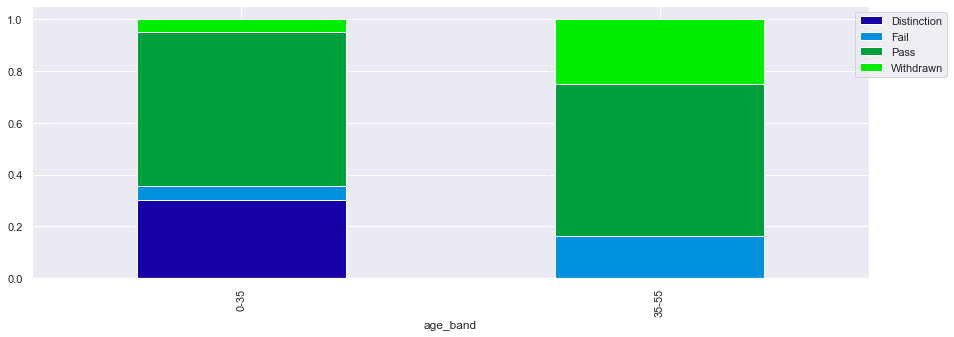

In [20]:
stacked_plot(df["age_band"])

For the assessment types, the levels were CMA (Computer Marked Assessment), TMA (Tutor Marked Assessment), and traditional Exam.

Interestingly, there were no Fail, Withdrawn, or Distinction results for the Exam level. For the TMA and CMA levels, the percentage of Pass results was the same for both types at 58%, which was similar to the outcome of Fail results at 17% and 21%, respectively. 

final_result     Distinction  Fail   Pass  Withdrawn    All
assessment_type                                            
CMA                     3500  2037   9489       1495  16521
Exam                       0     0    934          0    934
TMA                     5092  2718  17868       4781  30459
All                     8592  4755  28291       6276  47914
----------------------------------------------------------------------------------------------------


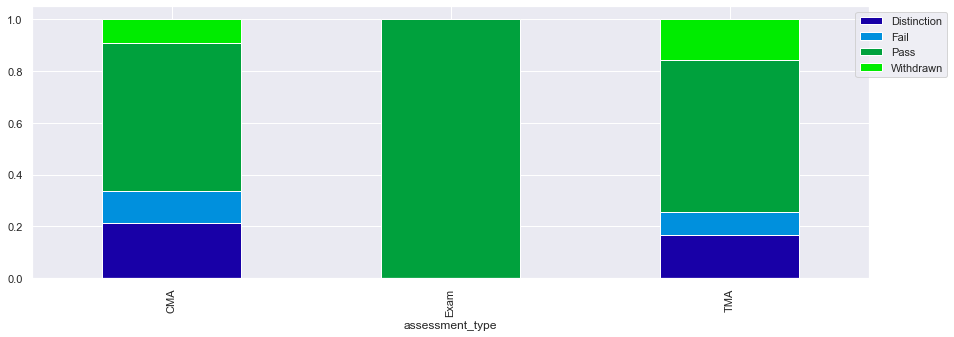

In [21]:
stacked_plot(df["assessment_type"])


For the continous variables, we chose to use box plots and histograms. The commented-out code below produces a loop that we used to review all of the continous variables, but we chose to focus on those variables that we had found outliers in.

In [22]:
#for i in conCol:
    #histogram_boxplot(ohdf[i])

The distribution of the "sum_click" (the number of times a student interacts with the online material in a day) showed several outliers from students who accessed their online courses more frequently, so much so that the mean value was pulled outside of the box, and a right skewed distribution.

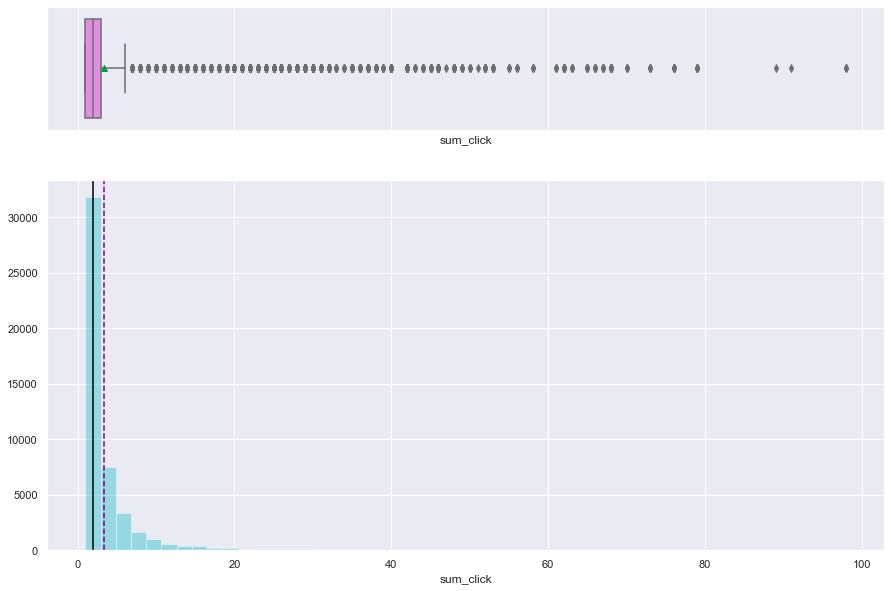

In [23]:
histogram_boxplot(df['sum_click'])

The output for "Score" (the actual assessment score) showed seven outliers on the left and a left skewed distribution. This indicated that there were only outliers from students who had performed very poorly on their assessments.

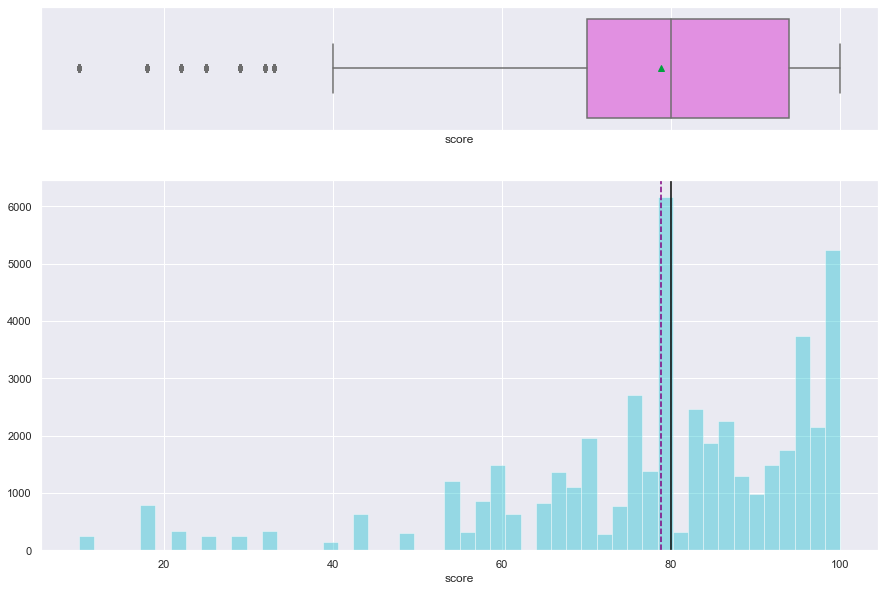

In [24]:
histogram_boxplot(df['score'])

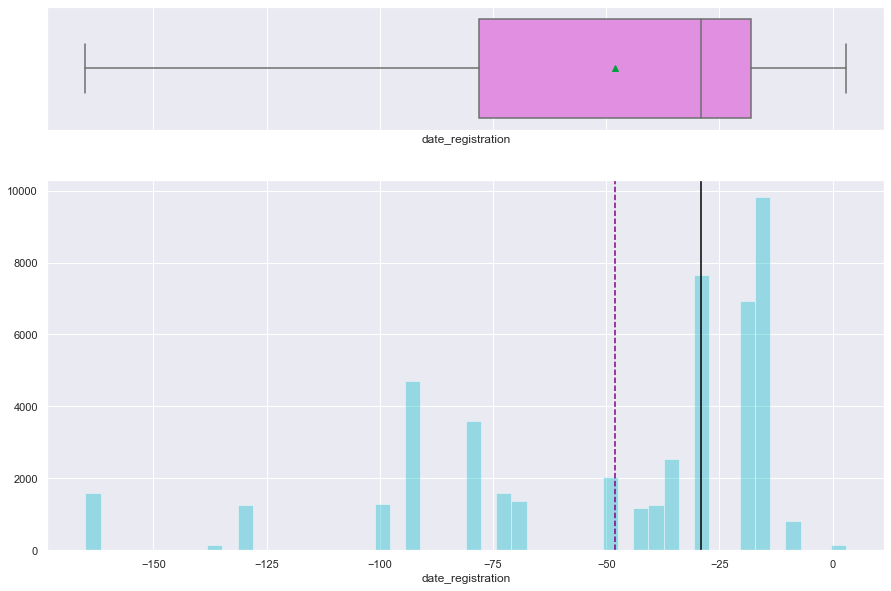

In [25]:
histogram_boxplot(df['date_registration'])

The box plot for "Weight" (calculated weights of the assessments) showed a single outlier, which likely indicated a course whose entire grade was based on a single assessment. 

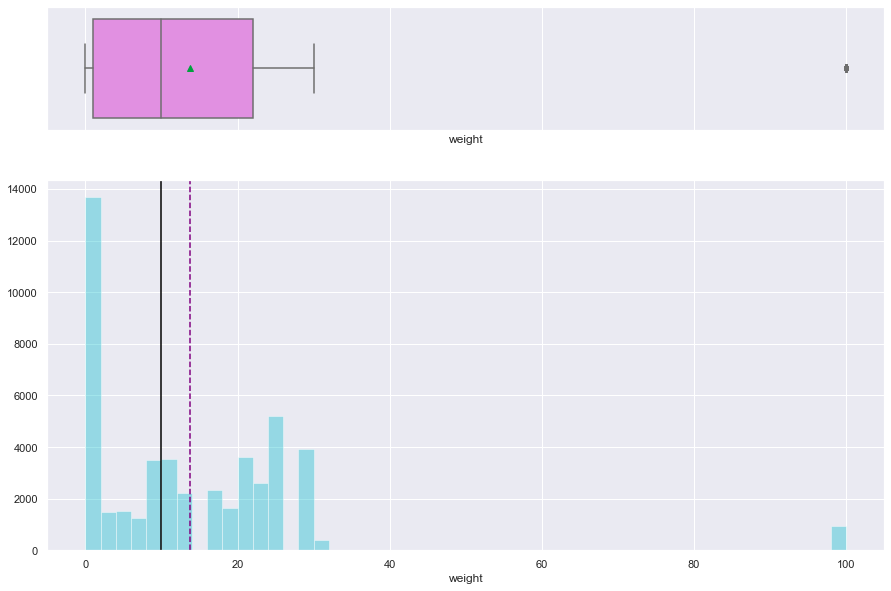

In [26]:
histogram_boxplot(df['weight'])

The box plot for "Date_Registration" (the number of days relative to the start of a course that a student registers for the course) indicated that the majority of students registered a few days before the course began,and no outliers were found.

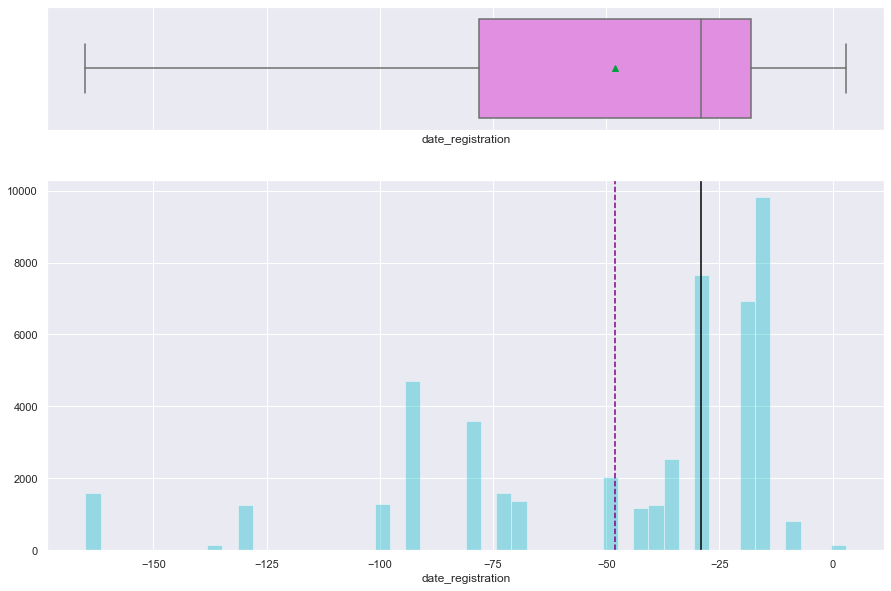

In [27]:
histogram_boxplot(df['date_registration'])

# Modeling and Evaluation 1 #
*Train and adjust parameters*

In [28]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.ensemble import RandomForestClassifier

# y = OneHotDF['final_result_Pass']
# X = OneHotDF[['num_of_prev_attempts','studied_credits','disability_N']]
# cv = StratifiedKFold(n_splits=10)
# # run at n =100
# clf = RandomForestClassifier(n_estimators=2,random_state= randomState)

# acc = cross_val_score(clf,X,y=y,cv=cv)

# print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

After randomly sampling the original OULAD, removing missing values, and One Hot Encoding the resulting dataset, we began the cluster analysis. We started by creating a K-Means clustering model using the **Number of Previous Attempts** and the **Final Result = Pass** variables. After some trial and error, we settled on n=4 clusters.

In [29]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Creating list of variables to create clusters with
clusterVars = ['num_of_prev_attempts_0', 'num_of_prev_attempts_1', 'num_of_prev_attempts_2', 'final_result_Pass']

X1 = OneHotDF[clusterVars]
#X1 = OneHotDF
nClusters = 4
cls = KMeans(n_clusters=nClusters, init='k-means++',random_state=randomState)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

# y = OneHotDF['Survived']
# X = OneHotDF[['Age','IsMale','Parch','SibSp']]
# X = np.column_stack((X,pd.get_dummies(newfeature)))
# acc = cross_val_score(cls,X,y=y,cv=cv)
# print ("Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100)

experimenting with model below

In [30]:
# Creating list of variables to create clusters with
clusterVars = ['num_of_prev_attempts', 'final_result_Pass']

#X1 = OneHotDF[clusterVars]
X1 = OneHotDF
nClusters = 4
cls = KMeans(n_clusters=nClusters, init='k-means++',random_state=randomState)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering



In the model below, we used the same dataset but with outliers removed. We found that accuracy increased to 80%.

In [32]:
#The following code was esed to check for any strongly correlated variables
#ohdf.corr()

# Modeling and Evaluation 2	#
*Evaluate and Compare*

In the following cells we applied the Robust Scaler to the dataset and used the Silhouette Score to calculate Goodness in an attempt to find the optimal number of clusters. We chose to loop through 49 clusters in order to find the optimal cluster and print a figure showing the Goodness score vs cluster. 

The results of the analysis showed that the best cluster in terms of goodness was k=27 which produced a goodness value 0.3885.

[Data Visualization in Python Talk](https://github.com/y2ee201/Data-Visualization-in-Python-Talk/blob/master/OULAD%20Student%20Segmentation%20.ipynb)

K = 3, Goodness = 0.1550893814527004
K = 5, Goodness = 0.21474102439902323
K = 7, Goodness = 0.2764272744507845
K = 9, Goodness = 0.31891218868598104
K = 11, Goodness = 0.3315662181873174
K = 13, Goodness = 0.33173580997191804
K = 15, Goodness = 0.3506275381822188
K = 17, Goodness = 0.3345637264963118
K = 19, Goodness = 0.3525161731581172
K = 21, Goodness = 0.32727396658143193
K = 23, Goodness = 0.34186066702066104
K = 25, Goodness = 0.3059465239129137
K = 27, Goodness = 0.306609944529859
K = 29, Goodness = 0.29923370632308327

The max goodness is 0.3525161731581172 at K = 19
CPU times: user 7min 6s, sys: 2min 14s, total: 9min 21s
Wall time: 4min 12s


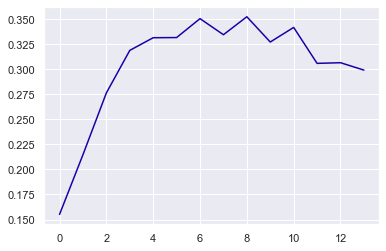

In [47]:
%%time
nclust = 30
cluster_goodness = []

for n in range(3,nclust,2):
    model = KMeans(n_clusters=n,random_state=randomState, init='k-means++')
    model.fit(data_clust)
    clusterLabels = model.labels_
    goodness = silhouette_score(X=data_clust, labels=clusterLabels)
    cluster_goodness.append([(n),goodness])
    print("K = {0}, Goodness = {1}".format(n, goodness))
    
cluster_goodness = pd.DataFrame.from_records(data = cluster_goodness,
                                            columns = ["n", "goodness"])

print('\nThe max goodness is',cluster_goodness.goodness.max(),
      'at K =',cluster_goodness.n[cluster_goodness.goodness.idxmax()])

plt.plot(cluster_goodness.goodness)

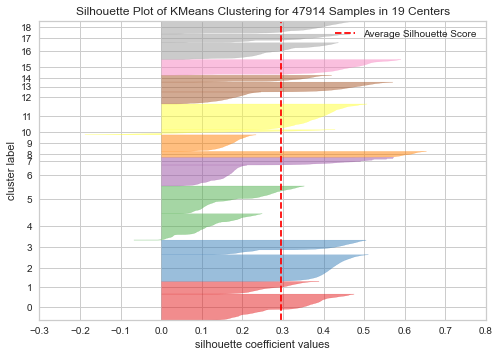

CPU times: user 1min 23s, sys: 24.7 s, total: 1min 48s
Wall time: 52.2 s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 47914 Samples in 19 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [56]:
%%time
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(19, random_state = randomState))
visualizer.fit(OneHotDF)    
visualizer.show();

The following cell uses the same approach stated above but uses the dataset with outliers included and no scaling algorithm.

In [46]:
print('The max goodness is',cluster_goodness.goodness.max(), 'at K =',cluster_goodness.n[cluster_goodness.goodness.idxmax()])

The max goodness is 0.3278182707962776 at K = 32


K = 3, Goodness = 0.1306331547530073
K = 5, Goodness = 0.16277124421706768
K = 7, Goodness = 0.20188815695268927
K = 9, Goodness = 0.24252705817119022
K = 11, Goodness = 0.2398725339322901
K = 13, Goodness = 0.2527681526704108
K = 15, Goodness = 0.2707480392977368
K = 17, Goodness = 0.2770080133421209
K = 19, Goodness = 0.29640395323892094
K = 21, Goodness = 0.2968539716234875
K = 23, Goodness = 0.3021475632162344
K = 25, Goodness = 0.3148009760539135
K = 27, Goodness = 0.31519258704539244
K = 29, Goodness = 0.2857795583141278

The max goodness is 0.31519258704539244 at K = 27
CPU times: user 10min 11s, sys: 3min 17s, total: 13min 28s
Wall time: 5min 57s


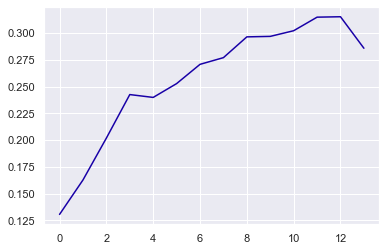

In [48]:
%%time
nclust = 30
cluster_goodness = []

for n in range(3,nclust,2):
    model = KMeans(n_clusters=n,random_state=randomState, init='k-means++')
    model.fit(OneHotDF)
    clusterLabels = model.labels_
    goodness = silhouette_score(X=OneHotDF, labels=clusterLabels)
    cluster_goodness.append([(n),goodness])
    print("K = {0}, Goodness = {1}".format(n, goodness))
    
cluster_goodness = pd.DataFrame.from_records(data = cluster_goodness,
                                            columns = ["n", "goodness"])

print('\nThe max goodness is',cluster_goodness.goodness.max(),
      'at K =',cluster_goodness.n[cluster_goodness.goodness.idxmax()])

plt.plot(cluster_goodness.goodness)

The following cell uses the dataset without outliers removed but applies the Robust Scaler to account for outliers without dropping any data.

K = 3, Goodness = 0.36652023034816195
K = 5, Goodness = 0.16544990293222656
K = 7, Goodness = 0.18380856423427214
K = 9, Goodness = 0.23169728537397283
K = 11, Goodness = 0.2658900638666577
K = 13, Goodness = 0.2907396132975066
K = 15, Goodness = 0.32400011443377424
K = 17, Goodness = 0.32408606212647983
K = 19, Goodness = 0.32072939773973
K = 21, Goodness = 0.3012706055315874
K = 23, Goodness = 0.28833836992554224
K = 25, Goodness = 0.30060185929909583
K = 27, Goodness = 0.3048126291324478
K = 29, Goodness = 0.3038357908574924

The max goodness is 0.36652023034816195 at K = 3
CPU times: user 10min 26s, sys: 3min 22s, total: 13min 48s
Wall time: 6min 17s


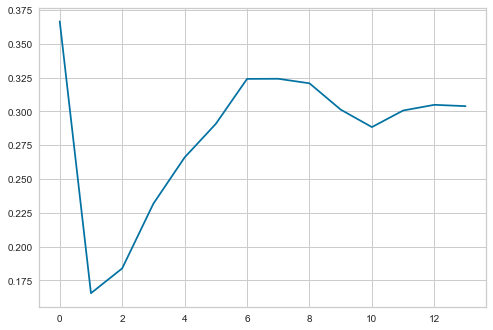

In [57]:
%%time
# K Means Goodness loop
nclust = 30
cluster_goodness = []

for n in range(3,nclust,2):
    model = KMeans(n_clusters=n,random_state=randomState, init='k-means++')
    model.fit(OneHotDF2)
    clusterLabels = model.labels_
    goodness = silhouette_score(X=OneHotDF2, labels=clusterLabels)
    cluster_goodness.append([(n),goodness])
    print("K = {0}, Goodness = {1}".format(n, goodness))
    
cluster_goodness = pd.DataFrame.from_records(data = cluster_goodness,
                                            columns = ["n", "goodness"])

print('\nThe max goodness is',cluster_goodness.goodness.max(),
      'at K =',cluster_goodness.n[cluster_goodness.goodness.idxmax()])

plt.plot(cluster_goodness.goodness)

Comparing K = 3 with K = 17

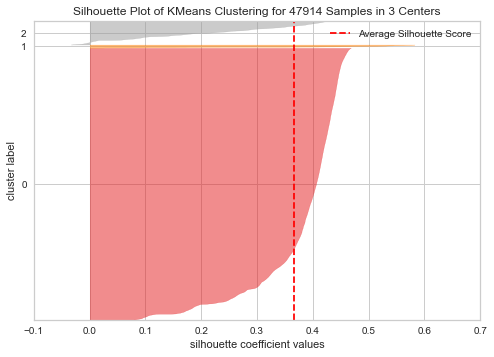

CPU times: user 1min 22s, sys: 21.2 s, total: 1min 43s
Wall time: 52.9 s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 47914 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [58]:
%%time
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = randomState))
visualizer.fit(OneHotDF2)    
visualizer.show();

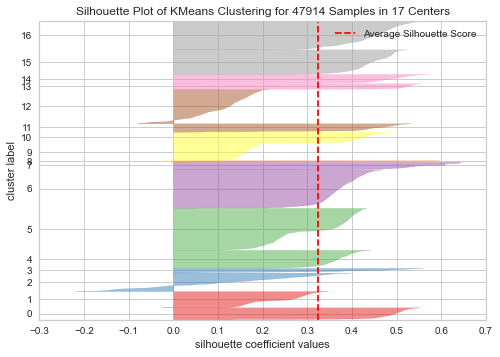

CPU times: user 1min 25s, sys: 26 s, total: 1min 51s
Wall time: 55.9 s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 47914 Samples in 17 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [59]:
%%time
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(17, random_state = randomState))
visualizer.fit(OneHotDF2)    
visualizer.show();

# Modeling and Evaluation 3 #
*Visualize Results*

Im trying to mess around with visualizing our cluster results: 

https://stackoverflow.com/questions/46844654/how-to-visualize-kmeans-clustering-on-multidimensional-data

https://stats.stackexchange.com/questions/52625/visually-plotting-multi-dimensional-cluster-data

# Modeling and Evaluation 4 #
*Summarize the Ramifications*

Unfortunately, our clustering models were based on what was essentially a snippet of a much larger dataset. This was done based on need because of the limitations of the hardware on our team's computers, which lacked the computational power to analyze the original dataset without suffering from extreme performance lag. The ramifications of our decision to significantly cut the dataset are that our models are unlikely to reflect the actual trends that exist in the dataset as a whole. As such, the models described herein cannot be generalized to the population as a whole, rather they are only reflective of the students within the subsample.

# Deployment #
*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?*

Taken as a whole, the OULAD is clearly an important dataset that can be used to better understand the factors that affect online students' assessment results and to better address those factors that can increase or decrease students' performance in an online environment. 

For this particular project, we were able to take a random subsample of the data and successfully create a series of clustering models with an accuracy of 80% by clustering "Number of Previous Attempts" and the "Pass" level from "Final Result". 

# Exceptional Work #

In [31]:
#emp & al stuff
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = ohdf['final_result_Pass']
X = ohdf[['num_of_prev_attempts_0','num_of_prev_attempts_1','num_of_prev_attempts_2','score', 'age_band_0-35']]
cv = StratifiedKFold(n_splits=10)
# run at n =100
clf = RandomForestClassifier(n_estimators=2,random_state= randomState)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  80.15439265975438 +- 11.763655784622236
